### This notebook will be mainly used for the capstone project

In [1]:
import pandas as pd
import numpy as np
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Table of Contents

<font size = 3>

1. <a href="#item1">Neighborhood Data</a>

2. <a href="#item2">Geolocation Data</a>

3. <a href="#item3">Venue Data</a>

4. <a href="#item4">Demographic Data</a>

5. <a href="#item5">Neighborhood Clustering</a>
    
6. <a href="#item6">Most Similar Neighborhood</a>

</font>
</div>

<a id='item1'></a>
## Part 1: Neighborhood Data

#### Get Data

In [2]:
import pandas as pd

url = "https://de.wikipedia.org/w/index.php?title=Verwaltungsgliederung_Berlins&oldid=198162445"
# Read raw data. The converter prevents the misinterpretation of the floats
rawdf = pd.read_html(url, converters={'Einwohner[2](30.\xa0Juni\xa02019)': str,
                                     'Fläche(km²)': str})[2] # We need table 3

In [3]:
rawdf.sample(5)

,Nr.,Ortsteil,Bezirk,Fläche(km²),Einwohner[2](30. Juni 2019),Einwohnerpro km²
41,605,Dahlem,Steglitz-Zehlendorf,839,16.836,2007.000
14,307,Pankow,Pankow,566,64.473,11.391
78,1104,Falkenberg,Lichtenberg,306,1.588,519.000
72,1003,Kaulsdorf,Marzahn-Hellersdorf,881,19.366,2198.000
27,407,Halensee,Charlottenburg-Wilmersdorf,127,15.556,12.249


#### Clean up formatting

In [4]:
# Rename columns to English
df = rawdf.rename(columns = {"Ortsteil": "Locality", "Bezirk": "District", 
                        "Fläche(km²)": "Area", rawdf.columns[-2]: "Population",
                        "Einwohnerpro km²": "Population_density"})

# Drop unnecessary columns
df.drop(columns = ["Population_density"], inplace = True)

# Deal with German number formatting
df.Area = df.Area.apply(lambda x: int(x) / 100) # in sq.km
df.Population = df.Population.apply(lambda x: int(x.replace('.', '')))

# Reorder columns
df = df[["Nr.", "District", "Locality", "Area", "Population"]]

In [5]:
df.sample(5).sort_index()

,Nr.,District,Locality,Area,Population
31,504,Spandau,Staaken,10.90,46223
44,701,Tempelhof-Schöneberg,Schöneberg,10.60,123680
70,1001,Marzahn-Hellersdorf,Marzahn,19.50,110415
79,1106,Lichtenberg,Malchow,1.54,636
80,1107,Lichtenberg,Wartenberg,6.92,2551


In [6]:
df.shape

(96, 5)

<a id='item2'></a>
## Part 2: Geolocation Data

In [7]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="berlin_explorer")

# Define function that fetches the coordinates of every locality
def get_neighborhood_coords(neighborhood, borough, city = "Berlin"):
    try:
        location = geolocator.geocode(", ".join([neighborhood, borough, city]))
        return location.latitude, location.longitude
    except:
        time.sleep(5)
        print("Failed to fetch location data of {}, {}. Retrying...".format(neighborhood, borough))
        return get_neighborhood_coords(neighborhood, borough, city)

In [8]:
df[["Latitude", "Longitude"]] = (df
      .apply(lambda row: get_neighborhood_coords(row.Locality, row.District), 
             axis = 1, result_type= "expand") # Apply function to every row
                                 )

Failed to fetch location data of Dahlem, Steglitz-Zehlendorf. Retrying...
Failed to fetch location data of Biesdorf, Marzahn-Hellersdorf. Retrying...
Failed to fetch location data of Wittenau, Reinickendorf. Retrying...


#### Dataframe with geolocation data

In [9]:
df.sample(5).sort_index()

,Nr.,District,Locality,Area,Population,Latitude,Longitude
26,406,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,6.20,19514,52.540525,13.296266
58,904,Treptow-Köpenick,Johannisthal,6.54,19840,52.445911,13.504547
75,1101,Lichtenberg,Friedrichsfelde,5.55,53411,52.502936,13.520546
76,1102,Lichtenberg,Karlshorst,6.60,27522,52.483703,13.523355
89,1205,Reinickendorf,Frohnau,7.80,16757,52.632392,13.287866


#### District-level dataframe

In [10]:
distdf = df.drop("Nr.", axis = 1).groupby("District", as_index = False).agg(
    {"Area": "sum", "Population": "sum", "Latitude": "mean", "Longitude": "mean"}
)

In [11]:
distdf

,District,Area,Population,Latitude,Longitude
0,Charlottenburg-Wilmersdorf,64.62,342332,52.502895,13.290267
1,Friedrichshain-Kreuzberg,20.18,289762,52.504930,13.431102
2,Lichtenberg,52.02,291452,52.537777,13.505225
3,Marzahn-Hellersdorf,61.71,268548,52.521925,13.583416
4,Mitte,39.48,384172,52.529623,13.361811
5,Neukölln,44.91,329691,52.437555,13.454288
6,Pankow,103.26,407765,52.588506,13.430079
7,Reinickendorf,89.40,265220,52.600226,13.302955
8,Spandau,91.90,243977,52.524715,13.189390
9,Steglitz-Zehlendorf,102.47,308697,52.438192,13.268392


#### Visualize neighborhoods

In [12]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Color each district differently
colors_array = cm.rainbow(np.linspace(0, 1, distdf.shape[0]))
district_colors = {}
for index, district in enumerate(distdf.District.values):
    district_colors[district] = colors.rgb2hex(colors_array[index])

In [13]:
import folium

berlin = geolocator.geocode("Berlin")
map_berlin = folium.Map(location = [berlin.latitude, berlin.longitude], zoom_start=10)

# Add individual localities to map
for lat, lng, locality, district in zip(df.Latitude, df.Longitude, df.Locality, df.District):
    label = folium.Popup(", ".join([locality, district]), parse_html = True)
    folium.CircleMarker(
        location = [lat, lng],
        radius = 5,
        popup = label,
        color = '#555555',
        fill = True,
        fill_color = district_colors[district],
        fill_opacity = 0.7,
        parse_html = False).add_to(map_berlin)

map_berlin

#### Compute locality radius

In [14]:
# Localities are of different sizes. Use the area to come up with a reasonable radius
# Radius = sqrt(Area/PI) / 2, rounded to 50m and maxed at 1500m
# The division by 2 is a fudge factor, since the localities are not circular
df["Radius"] = df.Area.apply(lambda A: int(min(round(np.sqrt(A / np.pi) * 1000, -2) / 2, 1500)))

Text(0.5, 0, 'Radius (m)')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


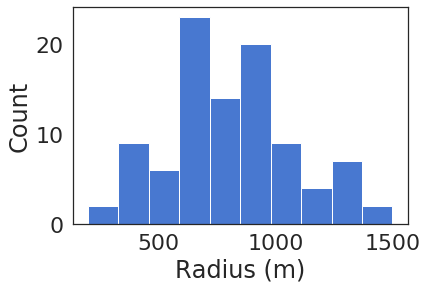

In [15]:
# Plot distribution of radii
%matplotlib inline
ax = df.Radius.plot(kind='hist')
ax.set_ylabel("Count")
ax.set_xlabel("Radius (m)")

In [16]:
df.head()

,Nr.,District,Locality,Area,Population,Latitude,Longitude,Radius
0,101,Mitte,Mitte,10.70,101932,52.517690,13.402376,900
1,102,Mitte,Moabit,7.72,79512,52.530102,13.342542,800
2,103,Mitte,Hansaviertel,0.53,5894,52.519123,13.341872,200
3,104,Mitte,Tiergarten,5.17,14753,52.509778,13.357260,650
4,105,Mitte,Wedding,9.23,86688,52.550123,13.341970,850


<a id='item3'></a>
## Part 3: Venue Data

#### Foursquare Credentials and Version

In [17]:
try:
    with open("foursquare.creds", 'r') as creds:
        CLIENT_ID, CLIENT_SECRET = creds.readline().rstrip("\n").split(",")
        print("CLIENT_ID = {}{}".format(CLIENT_ID[:3], '*' * (len(CLIENT_ID) - 3)))
        print("CLIENT_SECRET = {}{}".format(CLIENT_SECRET[:3], '*' * (len(CLIENT_SECRET) - 3)))
except FileNotFoundError:
    print("Make a 'foursquare.creds' file storing your Foursquare credentials!")
    CLIENT_ID = CLIENT_SECRET = ''

VERSION = '20200410' # Foursquare API version

CLIENT_ID = MUB*********************************************
CLIENT_SECRET = TEP*********************************************


#### Function  definitions

These are slightly refactored versions of the functions from the course

In [42]:
import requests

def explore_location(latitude, longitude, radius):
    # The only way to return all results is to use pages
    items_returned = 100
    offset = 0
    items = []
    while items_returned == 100: # loop through pages as long as there are more results
        url = 'https://api.foursquare.com/v2/venues/explore?' + \
            '&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=100&offset={}'\
            .format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, radius, offset)
        response = requests.get(url).json()["response"]
        if "groups" in response:
            returned = response['groups'][0]['items']
            items_returned = len(returned)
            items += returned
            offset += 100 # advance page
        else: # The call sometimes fails
            print("Failed to retrieve venues for ({},{})".format(latitude, longitude))
            print("Got:", response)
            print("Retrying...")
            return explore_location(latitude, longitude, radius)

    return items

In [43]:
# This is a premium call (not used)
def get_venue_rating(vid):
    # Create the API request URL
    url = 'https://api.foursquare.com/v2/venues/' + \
        '{}?&client_id={}&client_secret={}&v={}'.format(vid, CLIENT_ID, CLIENT_SECRET, VERSION)
    # Make the GET request
    response = requests.get(url).json()["response"]
    try:
        return response["venue"]["rating"]
    except:
        print("Failed to fetch rating for {}".format(vid))
        print("Got", response)
        return get_venue_rating(vid) # Try again on failure

In [44]:
# This is a regular call (not used, there are too many venues)
def get_venue_likes(vid, testing = True):
    if testing:
        return -1 # Don't waste API calls when testing
    else:
        # Create the API request URL
        url = ('https://api.foursquare.com/v2/venues/' + \
            '{}/likes?&client_id={}&client_secret={}&v={}'
            .format(vid, CLIENT_ID, CLIENT_SECRET, VERSION))
        # Make the GET request
        response = requests.get(url).json()["response"]
        try:
            return response["likes"]["count"]
        except:
            print("Failed to fetch likes count for {}".format(vid))
            print("Got", response)
            return get_venue_likes(vid) # Try again on failure

In [45]:
def extract_venue_info(json):
    return (json['name'], json['location']['lat'],
            json['location']['lng'], json['location']['distance'],
            json['categories'][0]['name'],
            # Take a prefix like "https://ss3.4sqi.net/img/categories_v2/nightlife/pub_" and...
            # ...extract "nightlife"
            json['categories'][0]['icon']['prefix'].split("categories_v2")[1][1:].split("/")[0],
            # ...and "pub"
            json['categories'][0]['icon']['prefix'].split("categories_v2")[1][1:].split("/")[1].rstrip("_"), 
            json['id'], get_venue_likes(json['id'])
           )

In [46]:
# Modified function from example notebook (different radii for different localities)
def get_nearby_venues(names, latitudes, longitudes, radii):
    venues_list = []
    for name, lat, lng, radius in zip(names, latitudes, longitudes, radii):
        results = explore_location(lat, lng, radius)
        # Return only relevant information for each nearby venue
        venues_list.append([(name, *extract_venue_info(v['venue'])) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Locality', 'Venue', 
                             'Latitude', 'Longitude', 'Distance',
                             'CategoryFull', 'Type','Category', 'Id', 'Likes']

    return(nearby_venues)

#### Function tests

In [47]:
sample = df.sample(1, random_state = 12).iloc[0]
explore_location(sample.Latitude, sample.Longitude, radius = 500)

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4dbd79e4815439392fb01b20',
   'name': 'Schloßpark-Grill',
   'location': {'address': 'Bäkestr. 9',
    'crossStreet': 'Hindenburgdamm',
    'lat': 52.43520835643327,
    'lng': 13.31328023857949,
    'labeledLatLngs': [{'label': 'display',
      'lat': 52.43520835643327,
      'lng': 13.31328023857949}],
    'distance': 235,
    'postalCode': '12207',
    'cc': 'DE',
    'neighborhood': 'Lichterfelde, Berlin',
    'city': 'Berlin',
    'state': 'Berlin',
    'country': 'Deutschland',
    'formattedAddress': ['Bäkestr. 9 (Hindenburgdamm)',
     '12207 Berlin',
     'Deutschland']},
   'categories': [{'id': '4bf58dd8d48988d109941735',
     'name': 'Eastern European Restaurant',
     'pluralName': 'Eastern European Restaurants',
     'shortName': 'Eastern European',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

In [48]:
get_venue_likes("4e0b6e0d63651cdae72cd154", False)

5

In [49]:
tmp = get_nearby_venues([sample.Locality], [sample.Latitude], [sample.Longitude], [sample.Radius])
print(tmp.Venue[0], get_venue_likes(tmp.Id[0], False), get_venue_rating(tmp.Id[0]))

Schloßpark-Grill 13 8.6


In [50]:
tmp.head(6)

,Locality,Venue,Latitude,Longitude,Distance,CategoryFull,Type,Category,Id,Likes
0,Lichterfelde,Schloßpark-Grill,52.435208,13.313280,235,Eastern European Restaurant,food,default,4dbd79e4815439392fb01b20,-1
1,Lichterfelde,La Malga,52.439900,13.315969,323,Italian Restaurant,food,italian,4f1ffa49e4b057da8c539ec9,-1
2,Lichterfelde,Da Remo,52.441284,13.314669,447,Italian Restaurant,food,italian,4ea8263d9adfcc4eb0d791f7,-1
3,Lichterfelde,Bao Vietnamese Cooking,52.446250,13.315415,1002,Vietnamese Restaurant,food,vietnamese,4dcfe032b0fb25f6e36710f6,-1
4,Lichterfelde,Tomasa,52.433795,13.317572,463,Café,food,cafe,513b2fc4e4b0809a1e3736b9,-1
5,Lichterfelde,Loch Ness Scottish Pub,52.446975,13.311626,1088,Whisky Bar,nightlife,whiskey,4cb8aa687148f04da1c3d1ab,-1


In [51]:
del(tmp) # Cleanup

#### Get venues

In [41]:
venues = get_nearby_venues(names = df.Locality, latitudes = df.Latitude, 
                           longitudes = df.Longitude, radii = df.Radius)

In [54]:
venues.sample(5)

,Locality,Venue,Latitude,Longitude,Distance,CategoryFull,Type,Category,Id,Likes
947,Pankow,Stück vom Glück,52.569199,13.400202,404,Café,food,cafe,51080ee219a999d47ad34a2f,-1
552,Friedrichshain,Cozys,52.511140,13.458485,567,Café,food,cafe,5471e754498eafa3c17a325f,-1
1228,Schmargendorf,Dschunke,52.474680,13.293508,471,Chinese Restaurant,food,asian,4cf7f90cc020b60ce54d2875,-1
1866,Tempelhof,Café Klangwerk,52.459551,13.382136,508,Café,food,cafe,57ce8ee638fa90334168747f,-1
672,Kreuzberg,Jivamukti Yoga,52.501412,13.420999,744,Yoga Studio,shops,gym_yogastudio,4efc34df9911cd89d0b03936,-1


In [55]:
# Check if all venues are unique
venues.loc[venues.duplicated(subset = "Id", keep = False)]

,Locality,Venue,Latitude,Longitude,Distance,CategoryFull,Type,Category,Id,Likes
2286,Niederschöneweide,metamorph marina,52.459332,13.516931,506,Harbor / Marina,parks_outdoors,harbor,51e68035498e1a6eb6ac9bb5,-1
2326,Oberschöneweide,metamorph marina,52.459332,13.516931,564,Harbor / Marina,parks_outdoors,harbor,51e68035498e1a6eb6ac9bb5,-1
2641,Wartenberg,Lidl,52.568789,13.519378,745,Supermarket,shops,food_grocery,4f083ab4e4b039f5acb1cc63,-1
2646,Wartenberg,Wartenberger Club,52.568889,13.516779,726,Gym / Fitness Center,building,gym,51926d3f498e472c9e65cbc8,-1
2647,Wartenberg,Domino's Pizza Berlin Hohenschönhausen,52.568760,13.518258,739,Pizza Place,food,pizza,5c5c2273da2e00002c1b6d53,-1
2650,Neu-Hohenschönhausen,Lidl,52.568789,13.519378,451,Supermarket,shops,food_grocery,4f083ab4e4b039f5acb1cc63,-1
2655,Neu-Hohenschönhausen,Wartenberger Club,52.568889,13.516779,338,Gym / Fitness Center,building,gym,51926d3f498e472c9e65cbc8,-1
2657,Neu-Hohenschönhausen,Domino's Pizza Berlin Hohenschönhausen,52.568760,13.518258,391,Pizza Place,food,pizza,5c5c2273da2e00002c1b6d53,-1


In [56]:
# Discard duplicate venues, keeping only the venue with the smallest distance
venues = (venues.sort_values(["Id", "Distance"]).drop_duplicates(subset = "Id", keep="first")
     .sort_index().reset_index(drop = True))

In [57]:
venues

,Locality,Venue,Latitude,Longitude,Distance,CategoryFull,Type,Category,Id,Likes
0,Mitte,Lustgarten,52.518469,13.399454,216,Garden,parks_outdoors,garden,4adcda7cf964a5205f4721e3,-1
1,Mitte,Kuppelumgang Berliner Dom,52.518966,13.400981,170,Scenic Lookout,parks_outdoors,sceniclookout,51838de5498e3fca634679a8,-1
2,Mitte,Radisson Blu,52.519561,13.402857,210,Hotel,travel,hotel,4b24db17f964a5202f6a24e3,-1
3,Mitte,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,265,Outdoor Sculpture,parks_outdoors,sculpture,4e50ee55483bb7704924391a,-1
4,Mitte,The Cathedral Museum,52.518606,13.400889,143,Museum,arts_entertainment,museum,583069e909239234ed0f5a0c,-1
...,...,...,...,...,...,...,...,...,...,...
2871,Märkisches Viertel,Märkische Zeile Berlin,52.599099,13.354791,120,Shopping Mall,shops,mall,4b8e7691f964a520e92333e3,-1
2872,Märkisches Viertel,Blixen Coffee Shop,52.597308,13.355109,242,Café,food,cafe,4b588aa5f964a520f15c28e3,-1
2873,Märkisches Viertel,Flamingo Ballpark,52.599845,13.349865,454,Baseball Field,parks_outdoors,baseballfield,4d986d07e07ea35d424ff102,-1
2874,Borsigwalde,POLO Motorrad Store,52.580640,13.303932,397,Motorcycle Shop,shops,motorcycle,4dbbdd0c43a1d8504b7b3f57,-1


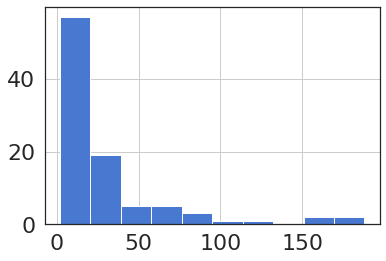

In [58]:
# Number of venues per locality
venues.groupby("Locality").count()["Venue"].hist()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


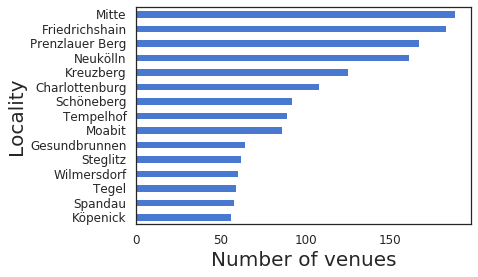

In [59]:
# Plot number of venues for localities with most venues
ax = (venues.groupby("Locality").filter(lambda x: len(x) > 50)
      .groupby("Locality").count()["Venue"].sort_values().plot.barh())
ax.set_xlabel("Number of venues")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
    item.set_fontsize(20)

#### Venue categories

In [60]:
print('There are {} unique full categories.'.format(len(venues['CategoryFull'].unique())))
print('There are {} unique types.'.format(len(venues['Type'].unique())))
print('There are {} unique categories.'.format(len(venues['Category'].unique())))
print('There are {} unique type-category combinations.'.format(venues.groupby(['Type', 'Category']).count().shape[0]))

There are 323 unique full categories.
There are 9 unique types.
There are 211 unique categories.
There are 218 unique type-category combinations.


In [61]:
# Prepend type to category to distinguish venue categories
venues["Category"] = venues["Type"] + "_"  + venues["Category"]

In [62]:
venues

,Locality,Venue,Latitude,Longitude,Distance,CategoryFull,Type,Category,Id,Likes
0,Mitte,Lustgarten,52.518469,13.399454,216,Garden,parks_outdoors,parks_outdoors_garden,4adcda7cf964a5205f4721e3,-1
1,Mitte,Kuppelumgang Berliner Dom,52.518966,13.400981,170,Scenic Lookout,parks_outdoors,parks_outdoors_sceniclookout,51838de5498e3fca634679a8,-1
2,Mitte,Radisson Blu,52.519561,13.402857,210,Hotel,travel,travel_hotel,4b24db17f964a5202f6a24e3,-1
3,Mitte,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,265,Outdoor Sculpture,parks_outdoors,parks_outdoors_sculpture,4e50ee55483bb7704924391a,-1
4,Mitte,The Cathedral Museum,52.518606,13.400889,143,Museum,arts_entertainment,arts_entertainment_museum,583069e909239234ed0f5a0c,-1
...,...,...,...,...,...,...,...,...,...,...
2871,Märkisches Viertel,Märkische Zeile Berlin,52.599099,13.354791,120,Shopping Mall,shops,shops_mall,4b8e7691f964a520e92333e3,-1
2872,Märkisches Viertel,Blixen Coffee Shop,52.597308,13.355109,242,Café,food,food_cafe,4b588aa5f964a520f15c28e3,-1
2873,Märkisches Viertel,Flamingo Ballpark,52.599845,13.349865,454,Baseball Field,parks_outdoors,parks_outdoors_baseballfield,4d986d07e07ea35d424ff102,-1
2874,Borsigwalde,POLO Motorrad Store,52.580640,13.303932,397,Motorcycle Shop,shops,shops_motorcycle,4dbbdd0c43a1d8504b7b3f57,-1


In [63]:
# The most frequent venue categories
venues.groupby("Category").count().sort_values("Venue")["Venue"][-10:].to_frame()

,Venue
Category,
food_default,67
travel_hotel,71
shops_pharmacy,78
travel_busstation,79
food_german,79
food_bakery,91
nightlife_pub,94
food_italian,123
food_cafe,177


In [64]:
# Categories that only appear once
np.unique(venues.groupby("Category").filter(lambda x: len(x) == 1).Category.values)

array(['arts_entertainment_arcade', 'arts_entertainment_casino',
       'arts_entertainment_comedyclub',
       'arts_entertainment_museum_planetarium',
       'arts_entertainment_museum_science',
       'arts_entertainment_waterpark', 'building_apartment',
       'building_religious_church', 'education_cafeteria',
       'education_lawschool', 'education_reccenter', 'event_default',
       'food_caribbean', 'food_cuban', 'food_cupcakes', 'food_dimsum',
       'food_frozenyogurt', 'food_hotdog', 'food_juicebar', 'food_ramen',
       'food_salad', 'food_scandinavian', 'food_soup', 'food_southern',
       'nightlife_karaoke', 'nightlife_secretbar',
       'parks_outdoors_bridge', 'parks_outdoors_farm',
       'parks_outdoors_mountain', 'parks_outdoors_naturepreserve',
       'parks_outdoors_volleyballcourt', 'shops_apparel_accessories',
       'shops_apparel_men', 'shops_camerastore', 'shops_comic',
       'shops_drycleaner', 'shops_food_foodcourt', 'shops_gamingcafe',
       'shops_hobb

In [65]:
len(np.unique(venues.groupby("Category").filter(lambda x: len(x) == 1).Category.values))

48

In [66]:
# The most frequent venue type
venues.groupby("Type").count().sort_values("Venue")["Venue"][-10:].to_frame()

,Venue
Type,
event,1
education,3
building,64
nightlife,169
arts_entertainment,173
parks_outdoors,236
travel,272
shops,722
food,1236


<a id='item4'></a>
## Part 4: Demographic Data

In [67]:
# Get data from Amt für Statistik Berlin-Brandenburg
url = "https://www.statistik-berlin-brandenburg.de/opendata/EWR_Ortsteile_2018-12-31.csv"
rawdemodf = pd.read_csv(url, encoding='ISO 8859-1', sep = ";")

In [68]:
# Table gives number of people of a particular gender and citizenship
# in each age group in the given locality
rawdemodf.head()

,Bezirk,Bez-Name,Ortsteil,Ortst-Name,Geschl,Staatsangeh,Altersgr,Häufigkeit
0,1,Mitte,101,Mitte,1,A,00_05,534
1,1,Mitte,101,Mitte,1,A,05_10,409
2,1,Mitte,101,Mitte,1,A,10_15,287
3,1,Mitte,101,Mitte,1,A,15_20,377
4,1,Mitte,101,Mitte,1,A,20_25,1181


In [69]:
rawdemodf.shape

(7194, 8)

In [70]:
# Pivot raw table by age
demodf = (rawdemodf.pivot_table(index = ["Bez-Name", "Ortst-Name"],
                values="Häufigkeit", columns="Altersgr", aggfunc="sum")
          .fillna(0).astype(int)) # replace missing values by 0

# Derived age categories
demodf["children"] = demodf["00_05"] + demodf["05_10"] + demodf["10_15"]
demodf["students"] = demodf["15_20"] + demodf["20_25"]
demodf["adults"] = (demodf["25_30"] + demodf["30_35"] + demodf["35_40"] + demodf["40_45"] +
                    demodf["45_50"] + demodf["50_55"] + demodf["55_60"] + demodf["60_65"])
demodf["seniors"] = (demodf["65_70"] + demodf["70_75"] + demodf["75_80"] + demodf["80_85"] +
                     demodf["85_90"] + demodf["90_95"] + demodf["95 und älter"])
demodf["total"] = demodf["children"] + demodf["students"] + demodf["adults"] + demodf["seniors"]
demodf["pct_children"] = demodf["children"] / demodf["total"]
demodf["pct_students"] = demodf["students"] / demodf["total"]
demodf["pct_adults"] = demodf["adults"] / demodf["total"]
demodf["pct_seniors"] = demodf["seniors"] / demodf["total"]

# Pivot and sum again, this time by gender
demodf["pct_men"] = (rawdemodf.pivot_table(index = ["Bez-Name", "Ortst-Name"],
                values="Häufigkeit", columns="Geschl", aggfunc="sum")[1]) / demodf["total"]

demodf["pct_women"] = 1 - demodf["pct_men"]

# And again, this time by citizenship
demodf["pct_foreigners"] = (rawdemodf.pivot_table(index = ["Bez-Name", "Ortst-Name"],
                values="Häufigkeit", columns="Staatsangeh", aggfunc="sum")["A"]) / demodf["total"]
demodf["pct_citizens"] = 1 - demodf["pct_foreigners"]

In [71]:
# Fix index
demodf.reset_index(inplace = True)
demodf.rename(columns = {"Bez-Name": "District", "Ortst-Name": "Locality"}, inplace = True)

In [72]:
# Keep only derived columns
demodf = demodf[["District", "Locality", "total", "pct_children", "pct_students", 
                 "pct_adults", "pct_seniors", "pct_men", "pct_women", 
                 "pct_foreigners", "pct_citizens"]]
demodf.rename(columns = dict([(c, c.replace("pct_", "")) for c in demodf.columns.values]),
              inplace = True)

In [73]:
demodf.sample(5)

Altersgr,District,Locality,total,children,students,adults,seniors,men,women,foreigners,citizens
57,Reinickendorf,Waidmannslust,10969,0.179232,0.109946,0.493846,0.216975,0.491294,0.508706,0.199380,0.800620
92,Treptow-Köpenick,Oberschöneweide,23130,0.143709,0.119023,0.611889,0.125378,0.512797,0.487203,0.167402,0.832598
56,Reinickendorf,Tegel,36508,0.112030,0.089405,0.534266,0.264298,0.485757,0.514243,0.136025,0.863975
90,Treptow-Köpenick,Müggelheim,6755,0.123908,0.067209,0.556773,0.252110,0.503479,0.496521,0.031384,0.968616
85,Treptow-Köpenick,Bohnsdorf,11692,0.131115,0.079285,0.552429,0.237171,0.491020,0.508980,0.045929,0.954071


<a id='item5'></a>
## 5. Neighborhood Clustering

### Clustering by venues

Encoding

In [74]:
# One hot encoding
categories_onehot = pd.get_dummies(venues[['Category']], prefix="", prefix_sep="")
types_onehot = pd.get_dummies(venues[['Type']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
categories_onehot['Locality'] = venues['Locality'] 
types_onehot['Locality'] = venues['Locality']

# Move neighborhood column to the first column
fixed_columns = [categories_onehot.columns[-1]] + list(categories_onehot.columns[:-1])
categories_onehot = categories_onehot[fixed_columns]
fixed_columns = [types_onehot.columns[-1]] + list(types_onehot.columns[:-1])
types_onehot = types_onehot[fixed_columns]

print(categories_onehot.shape)
print(types_onehot.shape)

(2876, 219)
(2876, 10)


Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [75]:
grouped_by_cat = categories_onehot.groupby('Locality').mean().reset_index()
grouped_by_type = types_onehot.groupby('Locality').mean().reset_index()

Get each neighborhood along with the top 10 most common venues

In [76]:
# Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    non0 = row_categories.values > 0 # Do not sort non-existent values
    row_categories_sorted = row_categories[non0].sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [77]:
def get_most_common_venues(num_categories, grouped_df, name):
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Locality']
    for ind in np.arange(num_categories):
        if ind < len(indicators):
            columns.append('{}{} {}'.format(ind+1, indicators[ind], name))
        else:
            columns.append('{}th {}'.format(ind+1, name))
    
    sorted_df = pd.DataFrame(columns = columns)
    sorted_df['Locality'] = grouped_df['Locality']
    
    for ind in np.arange(grouped_df.shape[0]):
        most_common_venues = return_most_common_venues(grouped_df.iloc[ind, :], num_categories)
        sorted_df.iloc[ind, 1:len(most_common_venues)+1] = most_common_venues
        sorted_df.iloc[ind, len(most_common_venues)+1:] = np.nan

    return sorted_df

In [78]:
venues_sorted_by_cat = get_most_common_venues(10, grouped_by_cat, "Category")
venues_sorted_by_type = get_most_common_venues(8, grouped_by_type, "Type")

In [56]:
# A sample of most common venue types
venues_sorted_by_type.sample(10, random_state=12).sort_index()

,Locality,1st Type,2nd Type,3rd Type,4th Type,5th Type,6th Type,7th Type,8th Type
7,Blankenfelde,shops,parks_outdoors,food,NaN,NaN,NaN,NaN,NaN
8,Bohnsdorf,shops,food,NaN,NaN,NaN,NaN,NaN,NaN
12,Buckow,shops,food,NaN,NaN,NaN,NaN,NaN,NaN
14,Charlottenburg-Nord,parks_outdoors,building,travel,shops,nightlife,food,arts_entertainment,NaN
17,Falkenhagener Feld,shops,food,arts_entertainment,NaN,NaN,NaN,NaN,NaN
38,Johannisthal,food,travel,arts_entertainment,shops,parks_outdoors,nightlife,NaN,NaN
40,Karow,shops,food,travel,NaN,NaN,NaN,NaN,NaN
60,Neu-Hohenschönhausen,shops,food,travel,parks_outdoors,building,arts_entertainment,NaN,NaN
66,Pankow,food,shops,building,nightlife,travel,parks_outdoors,NaN,NaN
85,Waidmannslust,shops,food,building,travel,NaN,NaN,NaN,NaN


In [57]:
# A sample of most common venue categories
venues_sorted_by_cat.sample(10, random_state=12).sort_index()

,Locality,1st Category,2nd Category,3rd Category,4th Category,5th Category,6th Category,7th Category,8th Category,9th Category,10th Category
7,Blankenfelde,shops_default,shops_automotive,parks_outdoors_hikingtrail,food_cafe,NaN,NaN,NaN,NaN,NaN,NaN
8,Bohnsdorf,shops_financial,shops_hardware,shops_food_grocery,food_italian,food_gastropub,NaN,NaN,NaN,NaN,NaN
12,Buckow,shops_food_grocery,shops_realestate,shops_discountstore,food_indian,food_german,food_fastfood,NaN,NaN,NaN,NaN
14,Charlottenburg-Nord,travel_subway,shops_food_grocery,parks_outdoors_rockclimbing,parks_outdoors_plaza,parks_outdoors_park,nightlife_beergarden,food_mexican,building_postoffice,building_default,arts_entertainment_stadium_soccer
17,Falkenhagener Feld,shops_pharmacy,shops_food_grocery,food_snacks,arts_entertainment_stadium_soccer,NaN,NaN,NaN,NaN,NaN,NaN
38,Johannisthal,travel_trainstation,travel_busstation,shops_food_grocery,parks_outdoors_park,nightlife_pub,food_sushi,food_pizza,food_greek,food_dessert,food_burger
40,Karow,shops_food_grocery,travel_busstation,food_german,food_default,NaN,NaN,NaN,NaN,NaN,NaN
60,Neu-Hohenschönhausen,shops_food_grocery,travel_trainstation,shops_technology,shops_pharmacy,shops_mall,shops_beauty_cosmetic,parks_outdoors_plaza,food_seafood,food_cafe,building_gym
66,Pankow,food_cafe,shops_food_grocery,building_gym,shops_pharmacy,food_italian,food_bakery,shops_default,nightlife_pub,food_sushi,food_german
85,Waidmannslust,building_gym,travel_lightrail,shops_technology,shops_pharmacy,shops_pet_store,shops_mall,shops_hardware,shops_food_grocery,shops_default,food_italian


#### Cluster neighborhoods

In [84]:
# Clustering matrices
cat_clustering = grouped_by_cat.drop('Locality', 1)
type_clustering = grouped_by_type.drop('Locality', 1)

Use Elbow method to find optimal K

In [85]:
# K-means clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

errors_cat = []
errors_type = []
for k in range(1, 15):
    cat_kmeans = KMeans(n_clusters = k, random_state = 12, n_init = 100).fit(cat_clustering)
    type_kmeans = KMeans(n_clusters = k, random_state = 12, n_init = 100).fit(type_clustering)
    # Compute error
    errors_cat.append(sum(np.min(cdist(cat_clustering, cat_kmeans.cluster_centers_, 'euclidean'), axis=1)) / cat_clustering.shape[0])
    errors_type.append(sum(np.min(cdist(type_clustering, type_kmeans.cluster_centers_, 'euclidean'), axis=1)) / type_clustering.shape[0])

(0.1, 0.35)

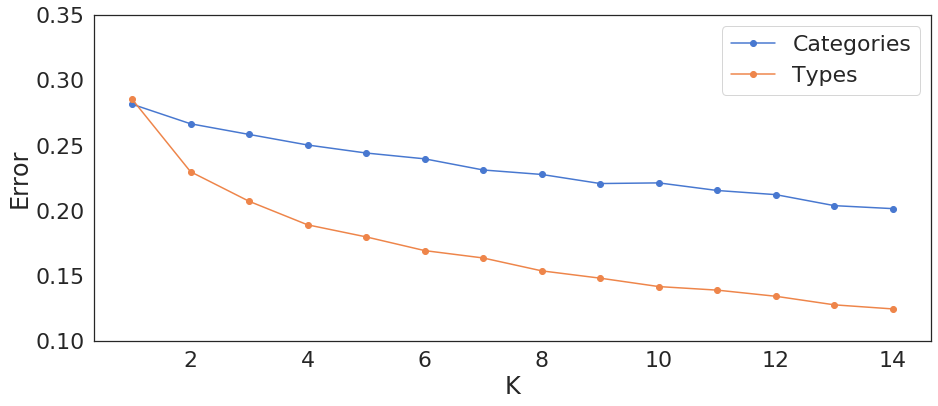

In [86]:
import matplotlib.pyplot as plt
# Errors by category vs type
plt.figure(figsize=(15,6))
plt.plot([x + 1 for x in range(len(errors_cat))], errors_cat, 'o-', 
         [x + 1 for x in range(len(errors_cat))], errors_type, 'o-')
plt.legend(["Categories", "Types"])
plt.ylabel("Error")
plt.xlabel("K")
plt.ylim([0.1, 0.35])

In [87]:
# Use "best" clustering
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state = 12, n_init = 100).fit(type_clustering)

In [63]:
kmeans.labels_

array([2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2,
       1, 1, 1, 0, 1, 0, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1,
       1, 1, 1, 0, 2, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 0, 2,
       1, 1, 1, 0, 0, 1, 1, 2], dtype=int32)

In [64]:
# Check cluster labels generated for each row in the dataframe
np.unique(kmeans.labels_, return_counts = True)

(array([0, 1, 2], dtype=int32), array([22, 39, 35]))

In [65]:
grouped_by_type

,Locality,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,Adlershof,0.000000,0.000000,0.0,0.357143,0.000000,0.071429,0.500000,0.071429
1,Alt-Hohenschönhausen,0.100000,0.000000,0.0,0.300000,0.000000,0.050000,0.450000,0.100000
2,Alt-Treptow,0.041667,0.041667,0.0,0.500000,0.083333,0.041667,0.166667,0.125000
3,Altglienicke,0.000000,0.000000,0.0,0.250000,0.000000,0.000000,0.500000,0.250000
4,Baumschulenweg,0.000000,0.000000,0.0,0.428571,0.000000,0.000000,0.428571,0.142857
...,...,...,...,...,...,...,...,...,...
91,Wilhelmsruh,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.666667
92,Wilhelmstadt,0.000000,0.000000,0.0,0.300000,0.000000,0.350000,0.100000,0.250000
93,Wilmersdorf,0.033898,0.033898,0.0,0.677966,0.016949,0.033898,0.169492,0.033898
94,Wittenau,0.142857,0.000000,0.0,0.571429,0.000000,0.142857,0.142857,0.000000


In [66]:
# Add clustering labels
grouped_by_type.insert(1, 'LocalityCluster', kmeans.labels_)

In [68]:
# Merge into original dataframe
df = (df.join(grouped_by_type.set_index("Locality"), on = "Locality"))

In [69]:
df

,Nr.,District,Locality,Area,Population,Latitude,Longitude,Radius,LocalityCluster,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,101,Mitte,Mitte,10.70,101932,52.517690,13.402376,900,1,0.185185,0.042328,0.0,0.328042,0.026455,0.084656,0.216931,0.116402
1,102,Mitte,Moabit,7.72,79512,52.530102,13.342542,800,1,0.023810,0.023810,0.0,0.607143,0.107143,0.000000,0.178571,0.059524
2,103,Mitte,Hansaviertel,0.53,5894,52.519123,13.341872,200,2,0.142857,0.000000,0.0,0.142857,0.000000,0.285714,0.428571,0.000000
3,104,Mitte,Tiergarten,5.17,14753,52.509778,13.357260,650,0,0.137931,0.000000,0.0,0.241379,0.103448,0.206897,0.034483,0.275862
4,105,Mitte,Wedding,9.23,86688,52.550123,13.341970,850,1,0.068182,0.000000,0.0,0.545455,0.045455,0.068182,0.227273,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1207,Reinickendorf,Waidmannslust,2.30,10958,52.605993,13.321046,450,2,0.000000,0.166667,0.0,0.166667,0.000000,0.000000,0.583333,0.083333
92,1208,Reinickendorf,Lübars,5.00,5174,52.614647,13.353020,650,1,0.000000,0.000000,0.0,0.750000,0.000000,0.250000,0.000000,0.000000
93,1209,Reinickendorf,Wittenau,5.90,24306,52.591237,13.323320,700,1,0.142857,0.000000,0.0,0.571429,0.000000,0.142857,0.142857,0.000000
94,1210,Reinickendorf,Märkisches Viertel,3.20,40258,52.599312,13.356532,500,1,0.000000,0.153846,0.0,0.384615,0.000000,0.153846,0.307692,0.000000


#### Examine clusters

In [70]:
tmp = df.copy()

In [71]:
c1 = (tmp
 .loc[tmp['LocalityCluster'] == 0, tmp.columns[[2] + list(range(9, tmp.shape[1]))]]
 .mean()
)

In [72]:
c2 = (tmp
 .loc[tmp['LocalityCluster'] == 1, tmp.columns[[2] + list(range(9, tmp.shape[1]))]]
 .mean()
)

In [73]:
c3 = (tmp
 .loc[tmp['LocalityCluster'] == 2, tmp.columns[[2] + list(range(9, tmp.shape[1]))]]
 .mean()
)

In [74]:
cluster_df = pd.DataFrame([c1, c2, c3])
cluster_df["Cluster"] = [1,2,3]
cluster_df.set_index("Cluster")

,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
Cluster,,,,,,,,
1,0.051193,0.015014,0.001623,0.215857,0.016764,0.246429,0.183052,0.270068
2,0.051492,0.027365,0.000242,0.549394,0.039199,0.076204,0.198390,0.057714
3,0.044593,0.027354,0.000000,0.268161,0.007492,0.060174,0.473055,0.119171


Visualize clusters

In [78]:
# create map
map_clusters = folium.Map(location=[berlin.latitude, berlin.longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.seismic(np.linspace(0.05, 0.7, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tmp['Latitude'], tmp['Longitude'], tmp['Locality'], tmp['LocalityCluster']):
    label = folium.Popup(str(poi) + ' (Cluster {})'.format(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
del(tmp)

### Clustering by demographics

In [90]:
# Merge demographic data into main data frame
df = (df.merge(demodf, left_on = ["District", "Locality"], right_on = ["District", "Locality"])
        .drop(columns = "Population").rename(columns = {"total": "Population"})
     )

In [91]:
# Normalize population and get normalized population density
df["population"] = df.Population / df.Population.max()
df["density"] = df.Population / df.Area
df["density"] = df["density"] / df["density"].max()

In [83]:
df

,Nr.,District,Locality,Area,Latitude,Longitude,Radius,LocalityCluster,arts_entertainment,building,...,children,students,adults,seniors,men,women,foreigners,citizens,population,density
0,101,Mitte,Mitte,10.70,52.517690,13.402376,900,1,0.185185,0.042328,...,0.124222,0.080722,0.663268,0.131787,0.509864,0.490136,0.301389,0.698611,0.605354,0.549996
1,102,Mitte,Moabit,7.72,52.530102,13.342542,800,1,0.023810,0.023810,...,0.123729,0.116995,0.636011,0.123265,0.523425,0.476575,0.317729,0.682271,0.476459,0.599988
2,103,Mitte,Hansaviertel,0.53,52.519123,13.341872,200,2,0.142857,0.000000,...,0.073129,0.142857,0.567177,0.216837,0.518027,0.481973,0.340986,0.659014,0.035199,0.645634
3,104,Mitte,Tiergarten,5.17,52.509778,13.357260,650,0,0.137931,0.000000,...,0.115529,0.116822,0.615222,0.152427,0.537613,0.462387,0.390632,0.609368,0.087931,0.165343
4,105,Mitte,Wedding,9.23,52.550123,13.341970,850,1,0.068182,0.000000,...,0.124216,0.118948,0.628444,0.128392,0.520988,0.479012,0.352380,0.647620,0.520374,0.548085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1207,Reinickendorf,Waidmannslust,2.30,52.605993,13.321046,450,2,0.000000,0.166667,...,0.179232,0.109946,0.493846,0.216975,0.491294,0.508706,0.199380,0.800620,0.065663,0.277539
92,1208,Reinickendorf,Lübars,5.00,52.614647,13.353020,650,1,0.000000,0.000000,...,0.141562,0.090646,0.507040,0.260752,0.493153,0.506847,0.057666,0.942334,0.031038,0.060348
93,1209,Reinickendorf,Wittenau,5.90,52.591237,13.323320,700,1,0.142857,0.000000,...,0.114170,0.097564,0.514860,0.273406,0.499310,0.500690,0.157531,0.842469,0.147440,0.242939
94,1210,Reinickendorf,Märkisches Viertel,3.20,52.599312,13.356532,500,1,0.000000,0.153846,...,0.195395,0.119231,0.474771,0.210603,0.482312,0.517688,0.237285,0.762715,0.238933,0.725872


In [92]:
demo_clustering = df[['children', 'students', 'adults', 'seniors', 'men',
       'women', 'foreigners', 'citizens', 'population', 'density']]

In [93]:
from scipy.spatial.distance import cdist

errors = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 12, n_init = 100).fit(demo_clustering)
    errors.append(sum(np.min(cdist(demo_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1) / demo_clustering.shape[0]))

(0.1, 0.35)

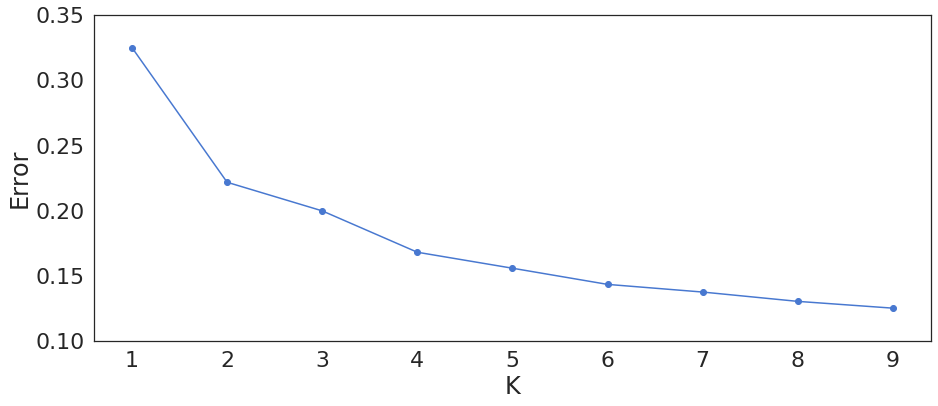

In [94]:
# Errors by category vs type
plt.figure(figsize=(15,6))
plt.plot([x + 1 for x in range(len(errors))], errors, 'o-')
plt.ylabel("Error")
plt.xlabel("K")
plt.ylim([0.1, 0.35])

In [87]:
# Use "best" clustering
kclusters = 4
kmeans = KMeans(n_clusters = kclusters, random_state = 12, n_init = 100).fit(demo_clustering)

In [88]:
kmeans.labels_

array([2, 0, 0, 3, 0, 2, 2, 2, 2, 3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 1, 2,
       2, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 1,
       2, 0, 3, 3, 3, 3, 2, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 3, 3, 1, 1, 1, 0, 3, 0, 3, 0, 1, 1,
       1, 1, 1, 3, 1, 3, 0, 1], dtype=int32)

In [89]:
# Check cluster labels generated for each row in the dataframe
np.unique(kmeans.labels_, return_counts = True)

(array([0, 1, 2, 3], dtype=int32), array([14, 43,  9, 30]))

In [90]:
# Add clustering labels
demo_clustering.insert(0, 'DemoCluster', kmeans.labels_)
demo_clustering.insert(0, "Locality", df.Locality)

In [91]:
demo_clustering

,Locality,DemoCluster,children,students,adults,seniors,men,women,foreigners,citizens,population,density
0,Mitte,2,0.124222,0.080722,0.663268,0.131787,0.509864,0.490136,0.301389,0.698611,0.605354,0.549996
1,Moabit,0,0.123729,0.116995,0.636011,0.123265,0.523425,0.476575,0.317729,0.682271,0.476459,0.599988
2,Hansaviertel,0,0.073129,0.142857,0.567177,0.216837,0.518027,0.481973,0.340986,0.659014,0.035199,0.645634
3,Tiergarten,3,0.115529,0.116822,0.615222,0.152427,0.537613,0.462387,0.390632,0.609368,0.087931,0.165343
4,Wedding,0,0.124216,0.118948,0.628444,0.128392,0.520988,0.479012,0.352380,0.647620,0.520374,0.548085
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Waidmannslust,3,0.179232,0.109946,0.493846,0.216975,0.491294,0.508706,0.199380,0.800620,0.065663,0.277539
92,Lübars,1,0.141562,0.090646,0.507040,0.260752,0.493153,0.506847,0.057666,0.942334,0.031038,0.060348
93,Wittenau,3,0.114170,0.097564,0.514860,0.273406,0.499310,0.500690,0.157531,0.842469,0.147440,0.242939
94,Märkisches Viertel,0,0.195395,0.119231,0.474771,0.210603,0.482312,0.517688,0.237285,0.762715,0.238933,0.725872


In [92]:
df.insert(df.columns.get_loc("Population"), 'DemoCluster', kmeans.labels_)

#### Examine clusters

In [93]:
tmp = demo_clustering.copy()

In [94]:
c1 = (tmp
 .loc[tmp['DemoCluster'] == 0, tmp.columns[[0] + list(range(2, tmp.shape[1]))]]
 .mean()
)

In [95]:
c2 = (tmp
 .loc[tmp['DemoCluster'] == 1, tmp.columns[[0] + list(range(2, tmp.shape[1]))]]
 .mean()
)

In [96]:
c3 = (tmp
 .loc[tmp['DemoCluster'] == 2, tmp.columns[[0] + list(range(2, tmp.shape[1]))]]
 .mean()
)

In [97]:
c4 = (tmp
 .loc[tmp['DemoCluster'] == 3, tmp.columns[[0] + list(range(2, tmp.shape[1]))]]
 .mean()
)

In [98]:
dcluster_df = pd.DataFrame([c1, c2, c3, c4])
dcluster_df["Cluster"] = [1,2,3,4]
dcluster_df.set_index("Cluster")

,children,students,adults,seniors,men,women,foreigners,citizens,population,density
Cluster,,,,,,,,,,
1,0.134015,0.100210,0.565230,0.200545,0.491465,0.508535,0.214015,0.785985,0.316882,0.680146
2,0.136134,0.085367,0.540726,0.237774,0.495925,0.504075,0.096325,0.903675,0.080748,0.105068
3,0.130668,0.093817,0.636547,0.138968,0.505625,0.494375,0.284216,0.715784,0.779866,0.782274
4,0.139882,0.096328,0.547936,0.215854,0.490507,0.509493,0.174710,0.825290,0.250328,0.269663


In [99]:
df

,Nr.,District,Locality,Area,Latitude,Longitude,Radius,LocalityCluster,arts_entertainment,building,...,children,students,adults,seniors,men,women,foreigners,citizens,population,density
0,101,Mitte,Mitte,10.70,52.517690,13.402376,900,1,0.185185,0.042328,...,0.124222,0.080722,0.663268,0.131787,0.509864,0.490136,0.301389,0.698611,0.605354,0.549996
1,102,Mitte,Moabit,7.72,52.530102,13.342542,800,1,0.023810,0.023810,...,0.123729,0.116995,0.636011,0.123265,0.523425,0.476575,0.317729,0.682271,0.476459,0.599988
2,103,Mitte,Hansaviertel,0.53,52.519123,13.341872,200,2,0.142857,0.000000,...,0.073129,0.142857,0.567177,0.216837,0.518027,0.481973,0.340986,0.659014,0.035199,0.645634
3,104,Mitte,Tiergarten,5.17,52.509778,13.357260,650,0,0.137931,0.000000,...,0.115529,0.116822,0.615222,0.152427,0.537613,0.462387,0.390632,0.609368,0.087931,0.165343
4,105,Mitte,Wedding,9.23,52.550123,13.341970,850,1,0.068182,0.000000,...,0.124216,0.118948,0.628444,0.128392,0.520988,0.479012,0.352380,0.647620,0.520374,0.548085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1207,Reinickendorf,Waidmannslust,2.30,52.605993,13.321046,450,2,0.000000,0.166667,...,0.179232,0.109946,0.493846,0.216975,0.491294,0.508706,0.199380,0.800620,0.065663,0.277539
92,1208,Reinickendorf,Lübars,5.00,52.614647,13.353020,650,1,0.000000,0.000000,...,0.141562,0.090646,0.507040,0.260752,0.493153,0.506847,0.057666,0.942334,0.031038,0.060348
93,1209,Reinickendorf,Wittenau,5.90,52.591237,13.323320,700,1,0.142857,0.000000,...,0.114170,0.097564,0.514860,0.273406,0.499310,0.500690,0.157531,0.842469,0.147440,0.242939
94,1210,Reinickendorf,Märkisches Viertel,3.20,52.599312,13.356532,500,1,0.000000,0.153846,...,0.195395,0.119231,0.474771,0.210603,0.482312,0.517688,0.237285,0.762715,0.238933,0.725872


Visualize clusters

In [100]:
# create map
map_clusters = folium.Map(location=[berlin.latitude, berlin.longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.seismic(np.linspace(0.05, 0.95, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Locality'], df['DemoCluster']):
    label = folium.Popup(str(poi) + ' (Cluster {})'.format(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Overlap between clusters 

In [220]:
odf = df[["Locality", "LocalityCluster", "DemoCluster"]]

In [221]:
odf.LocalityCluster += 1
odf.DemoCluster += 1

/Users/matr012/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [223]:
(odf[["Locality", "LocalityCluster", "DemoCluster"]]
     .rename(columns = {"DemoCluster": "Demographics Cluster", "LocalityCluster": "Venues Cluster"})
     .groupby(["Venues Cluster", "Demographics Cluster"])
     .size().to_frame(name = "Count")
)

Count
Venues Cluster Demographics Cluster       
1              1                         2
               2                        12
               4                         8
2              1                         5
               2                        13
               3                         9
               4                        12
3              1                         7
               2                        18
               4                        10

In [224]:
(odf[["Locality", "LocalityCluster", "DemoCluster"]]
     .rename(columns = {"DemoCluster": "Demographics Cluster", "LocalityCluster": "Venues Cluster"})
     .groupby(["Demographics Cluster", "Venues Cluster"])
     .size().to_frame(name = "Count")
)

Count
Demographics Cluster Venues Cluster       
1                    1                   2
                     2                   5
                     3                   7
2                    1                  12
                     2                  13
                     3                  18
3                    2                   9
4                    1                   8
                     2                  12
                     3                  10

<a id='item6'></a>
## 6. Most Similar Neighborhood

In [101]:
df.columns

Index(['Nr.', 'District', 'Locality', 'Area', 'Latitude', 'Longitude',
       'Radius', 'LocalityCluster', 'arts_entertainment', 'building',
       'education', 'food', 'nightlife', 'parks_outdoors', 'shops', 'travel',
       'DemoCluster', 'Population', 'children', 'students', 'adults',
       'seniors', 'men', 'women', 'foreigners', 'citizens', 'population',
       'density'],
      dtype='object')

In [102]:
df2 = df[['Locality', 'arts_entertainment', 'building',
       'education', 'food', 'nightlife', 'parks_outdoors', 'shops', 'travel',
       'Population', 'children', 'students', 'adults', 'seniors', 'men',
       'women', 'foreigners', 'citizens', 'population', 'density']]

In [103]:
# Columns to consider for computing similarity (eliminate redundant features)
tmp_cols = [c for c in list(df2.columns) if c not in ["Locality", "Population", "education", 
                                                      "adults", "citizens", "men"]]
tmp_cols

['arts_entertainment',
 'building',
 'food',
 'nightlife',
 'parks_outdoors',
 'shops',
 'travel',
 'children',
 'students',
 'seniors',
 'women',
 'foreigners',
 'population',
 'density']

In [104]:
# For each locality compute the cosine similarity between its feature vector and the
# feature vector of every other locality
for row in df.Locality.values:
    y0 = df2.loc[df2.Locality == row, tmp_cols].values # feature vector of locality i
    y0_norm = np.sqrt(np.inner(y0, y0)[0,0])           # norm of feature vector
    for col in df.Locality.values:
        y1 = df2.loc[df2.Locality == col, tmp_cols].values # feature vector of locality j
        y1_norm = np.sqrt(np.inner(y1, y1)[0,0])           # norm of feature vector
        dot_prod = np.inner(y0, y1)[0,0]                   # dot product between the two
        df2.loc[df2.Locality == row, col] = dot_prod / y0_norm / y1_norm # cosine similarity
    df2.loc[df2.Locality == row, row] = -99 # ignore self

/Users/matr012/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/matr012/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [105]:
# Sample of resulting matrix
df2[["Locality"] + list(df.Locality.values)].iloc[0:8]

,Locality,Mitte,Moabit,Hansaviertel,Tiergarten,Wedding,Gesundbrunnen,Friedrichshain,Kreuzberg,Prenzlauer Berg,...,Tegel,Konradshöhe,Heiligensee,Frohnau,Hermsdorf,Waidmannslust,Lübars,Wittenau,Märkisches Viertel,Borsigwalde
0,Mitte,-99.000000,0.946401,0.797653,0.767006,0.969561,0.963663,0.963996,0.967381,0.949977,...,0.783097,0.682358,0.566424,0.683803,0.703912,0.726249,0.579937,0.809686,0.898017,0.689027
1,Moabit,0.946401,-99.000000,0.765721,0.751292,0.991550,0.963482,0.961131,0.953263,0.948253,...,0.823139,0.785715,0.491553,0.796040,0.735121,0.710995,0.709551,0.873457,0.919718,0.828644
2,Hansaviertel,0.797653,0.765721,-99.000000,0.750164,0.794265,0.836496,0.717623,0.712789,0.671682,...,0.691474,0.637735,0.682644,0.632281,0.775510,0.843858,0.529174,0.756556,0.915652,0.654418
3,Tiergarten,0.767006,0.751292,0.750164,-99.000000,0.771433,0.721269,0.648565,0.638414,0.594827,...,0.775440,0.756035,0.544771,0.697854,0.659241,0.677849,0.705488,0.811447,0.732389,0.701790
4,Wedding,0.969561,0.991550,0.794265,0.771433,-99.000000,0.966439,0.961116,0.959653,0.949846,...,0.835663,0.768223,0.531501,0.787975,0.755295,0.732440,0.697933,0.877791,0.920390,0.811633
5,Gesundbrunnen,0.963663,0.963482,0.836496,0.721269,0.966439,-99.000000,0.969148,0.969133,0.950348,...,0.707193,0.658667,0.492362,0.655962,0.662604,0.705145,0.558891,0.779937,0.944725,0.689540
6,Friedrichshain,0.963996,0.961131,0.717623,0.648565,0.961116,0.969148,-99.000000,0.996734,0.995293,...,0.719224,0.641296,0.442728,0.659470,0.633332,0.625425,0.564144,0.762751,0.880423,0.671981
7,Kreuzberg,0.967381,0.953263,0.712789,0.638414,0.959653,0.969133,0.996734,-99.000000,0.994884,...,0.697930,0.607889,0.424170,0.631973,0.610401,0.610555,0.535916,0.745073,0.870061,0.645941


In [106]:
# Now sort the rows of the matrix to get the most and least similar neighborhoods
indicators = ['st', 'nd', 'rd', 'th', 'th']
for row in df.Locality.values:
    most_similar = df2.loc[df2.Locality == row, df.Locality.values].squeeze().nlargest(3).index
    least_similar = (df2.loc[df2.Locality == row, df.Locality.values]
                     .squeeze().nsmallest(4)[1:].index)
    for index, (sloc, dloc) in enumerate(zip(most_similar, least_similar)):
        df2.loc[df2.Locality == row, str(index + 1) + indicators[index] + " Similar"] = sloc        
        df2.loc[df2.Locality == row, str(index + 1) + indicators[index] + " Dissimilar"] = dloc

In [108]:
simdf = df2[["Locality",
                 "1st Similar", "2nd Similar", "3rd Similar",
                 "1st Dissimilar", "2nd Dissimilar", "3rd Dissimilar"]]

#### Full similarity results

In [109]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(simdf)

,Locality,1st Similar,2nd Similar,3rd Similar,1st Dissimilar,2nd Dissimilar,3rd Dissimilar
0,Mitte,Charlottenburg,Wedding,Kreuzberg,Stadtrandsiedlung Malchow,Malchow,Falkenberg
1,Moabit,Wedding,Wilmersdorf,Schöneberg,Stadtrandsiedlung Malchow,Plänterwald,Heiligensee
2,Hansaviertel,Fennpfuhl,Gropiusstadt,Friedenau,Malchow,Stadtrandsiedlung Malchow,Plänterwald
3,Tiergarten,Grunewald,Wilhelmstadt,Rummelsburg,Stadtrandsiedlung Malchow,Heiligensee,Malchow
4,Wedding,Moabit,Charlottenburg,Schöneberg,Stadtrandsiedlung Malchow,Plänterwald,Wilhelmsruh
5,Gesundbrunnen,Friedrichshain,Kreuzberg,Wilmersdorf,Stadtrandsiedlung Malchow,Malchow,Wartenberg
6,Friedrichshain,Kreuzberg,Prenzlauer Berg,Neukölln,Stadtrandsiedlung Malchow,Plänterwald,Heiligensee
7,Kreuzberg,Friedrichshain,Prenzlauer Berg,Neukölln,Stadtrandsiedlung Malchow,Plänterwald,Heiligensee
8,Prenzlauer Berg,Friedrichshain,Kreuzberg,Neukölln,Stadtrandsiedlung Malchow,Plänterwald,Heiligensee
9,Weißensee,Rummelsburg,Lichterfelde,Niederschönhausen,Stadtrandsiedlung Malchow,Heiligensee,Wartenberg


In [193]:
# Most "typical" localities
most_typical = (pd.concat([simdf["1st Similar"], simdf["2nd Similar"], simdf["3rd Similar"]])
     .value_counts().to_frame(name = "Count")
)
most_typical = most_typical[most_typical.Count > 4]

In [194]:
# List all similar localities for most typical localities
for row in most_typical.index.values:
    most_typical.loc[row, "Similar Localities"] = (", "
           .join(sorted(simdf.loc[
               (simdf["1st Similar"] == row) | 
               (simdf["2nd Similar"] == row) | 
               (simdf["3rd Similar"] == row)
           ].Locality.values)))

In [195]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(most_typical)

,Count,Similar Localities
Lichtenrade,8,"Alt-Hohenschönhausen, Buckow, Falkenhagener Feld, Mariendorf, Niederschönhausen, Rudow, Tempelhof, Zehlendorf"
Mariendorf,7,"Alt-Hohenschönhausen, Buckow, Falkenhagener Feld, Lichtenrade, Spandau, Tempelhof, Zehlendorf"
Kreuzberg,7,"Charlottenburg, Friedrichshain, Gesundbrunnen, Mitte, Neukölln, Prenzlauer Berg, Schöneberg"
Heinersdorf,6,"Altglienicke, Buch, Französisch Buchholz, Heiligensee, Siemensstadt, Waidmannslust"
Nikolassee,6,"Charlottenburg-Nord, Gatow, Grunewald, Grünau, Schmöckwitz, Wannsee"
Niederschönhausen,6,"Baumschulenweg, Karlshorst, Karow, Marienfelde, Staaken, Weißensee"
Frohnau,6,"Blankenburg, Borsigwalde, Friedrichshagen, Konradshöhe, Lübars, Müggelheim"
Friedrichshagen,6,"Blankenburg, Frohnau, Konradshöhe, Müggelheim, Rahnsdorf, Tegel"
Alt-Hohenschönhausen,6,"Buckow, Falkenhagener Feld, Lichtenrade, Mariendorf, Spandau, Staaken"
Friedrichshain,6,"Charlottenburg, Gesundbrunnen, Kreuzberg, Neukölln, Prenzlauer Berg, Schöneberg"


In [211]:
# Features of most typical localities
df.loc[df.Locality.isin(["Lichtenrade", "Mariendorf", "Kreuzberg"]), ["Locality"] + tmp_cols]

,Locality,arts_entertainment,building,food,nightlife,parks_outdoors,shops,travel,children,students,seniors,women,foreigners,population,density
7,Kreuzberg,0.080000,0.016,0.528000,0.112,0.056000,0.184000,0.024000,0.138866,0.103755,0.105879,0.486844,0.313589,0.930051,0.869376
47,Mariendorf,0.040000,0.040,0.360000,0.000,0.080000,0.440000,0.040000,0.118915,0.091387,0.257484,0.520338,0.173971,0.315532,0.327021
49,Lichtenrade,0.086957,0.000,0.391304,0.000,0.043478,0.434783,0.043478,0.139027,0.096265,0.271696,0.518910,0.115669,0.308810,0.297238


In [197]:
# Most unique localities
most_unique = (pd.concat([simdf["1st Dissimilar"], simdf["2nd Dissimilar"], simdf["3rd Dissimilar"]])
     .value_counts().to_frame(name = "Number of dissimilar localities")
)
most_unique[most_unique["Number of dissimilar localities"] > 5]

,Number of dissimilar localities
Stadtrandsiedlung Malchow,79
Plänterwald,46
Malchow,35
Wilhelmsruh,34
Neukölln,23
Heiligensee,20
Falkenberg,20
Prenzlauer Berg,11
Kreuzberg,7
Wartenberg,6
